In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt


In [2]:
# 1. 加载数据
file_path = r'D:\Pythonworkshop\Solar_data_processing\cleaned_data_final_Yulara.csv'
data = pd.read_csv(file_path)

# 删除时间戳列
if 'timestamp' in data.columns:
    data = data.drop(columns=['timestamp'])

# 添加前一时刻的功率数据作为新的特征
data['Prev_Power'] = data['Active_Power'].shift(1)
data['Prev_Power'] = data['Prev_Power'].fillna(0)  # 处理缺失值

# 数据集划分
X = data.drop(columns=['Active_Power'])
y = data['Active_Power']

# 假设 X 和 y 是你的特征和标签数据
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]


# 使用训练集数据进行归一化
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# 仅使用训练集数据拟合scaler
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

# 使用训练集的归一化参数对验证集和测试集进行归一化
X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

Trial 20 Complete [00h 02m 28s]
val_loss: 0.009971089661121368

Best val_loss So Far: 0.009885895997285843
Total elapsed time: 00h 32m 38s
Epoch 1/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step - loss: 0.0302 - val_loss: 0.0227
Epoch 2/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/step - loss: 0.0102 - val_loss: 0.0139
Epoch 3/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - loss: 0.0102 - val_loss: 0.0147
Epoch 4/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - loss: 0.0097 - val_loss: 0.0138
Epoch 5/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - loss: 0.0092 - val_loss: 0.0126
Epoch 6/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - loss: 0.0090 - val_loss: 0.0116
Epoch 7/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step - loss: 0.0094 - val_loss: 0.0117
Epoch 8/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step - loss: 0.0090 - val_loss: 0.0120
Epoch 9/100
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - loss: 0.0086 - val_loss: 0.0136
Epoch 10/100
1142/1142 ━━━━━━━━━━━━━━━━━━━

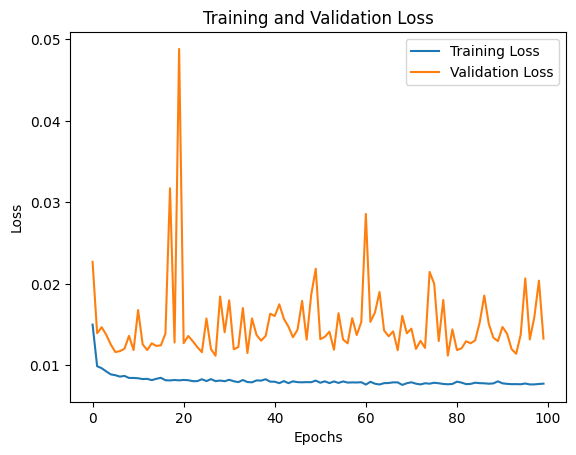

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from keras_tuner import BayesianOptimization
import matplotlib.pyplot as plt
import json
import numpy as np

# 定义LNN Layer
class LNNLayer(layers.Layer):
    def __init__(self, input_size, hidden_size):
        super(LNNLayer, self).__init__()
        self.hidden_size = hidden_size
        self.W_in = self.add_weight(shape=(input_size, hidden_size), initializer='random_normal', trainable=True)
        self.W_rec = self.add_weight(shape=(hidden_size, hidden_size), initializer='random_normal', trainable=True)
        self.W_tau = self.add_weight(shape=(input_size + hidden_size, hidden_size), initializer='random_normal', trainable=True)
        self.activation = tf.nn.tanh
        self.tau_activation = tf.nn.softplus

    def call(self, inputs, state):
        new_state = self.activation(tf.matmul(inputs, self.W_in) + tf.matmul(state, self.W_rec))
        combined = tf.concat([inputs, state], axis=-1)
        tau = self.tau_activation(tf.matmul(combined, self.W_tau))
        state = state + (1.0 / tau) * (new_state - state)
        return state

# 定义LNN Model
class LNNModel(tf.keras.Model):
    def __init__(self, input_size, hidden_size, output_size):
        super(LNNModel, self).__init__()
        self.lnn_layer = LNNLayer(input_size, hidden_size)
        self.fc = layers.Dense(output_size)

    def call(self, inputs):
        state = tf.zeros((tf.shape(inputs)[0], self.lnn_layer.hidden_size))
        state = self.lnn_layer(inputs, state)
        output = self.fc(state)
        return output

# 构建模型的函数，供Keras Tuner使用
def build_model(hp):
    input_size = X_train_scaled.shape[1]
    hidden_size = hp.Int('hidden_size', min_value=32, max_value=256, step=32)
    output_size = 1
    
    model = LNNModel(input_size, hidden_size, output_size)
    
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    
    return model

# 使用Keras Tuner进行贝叶斯优化
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    directory='my_dir',
    project_name='lnn_model_tuning'
)

# 运行超参数搜索
tuner.search(X_train_scaled, y_train_scaled, epochs=100, validation_data=(X_val_scaled, y_val_scaled), batch_size=64)

# 获取最佳超参数
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# 保存最佳超参数到JSON文件
best_hps_dict = best_hps.values
with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_hps_dict, f)

# 使用最佳超参数训练模型
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, validation_data=(X_val_scaled, y_val_scaled), batch_size=64)

# 可视化训练和验证损失曲线
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()



490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step


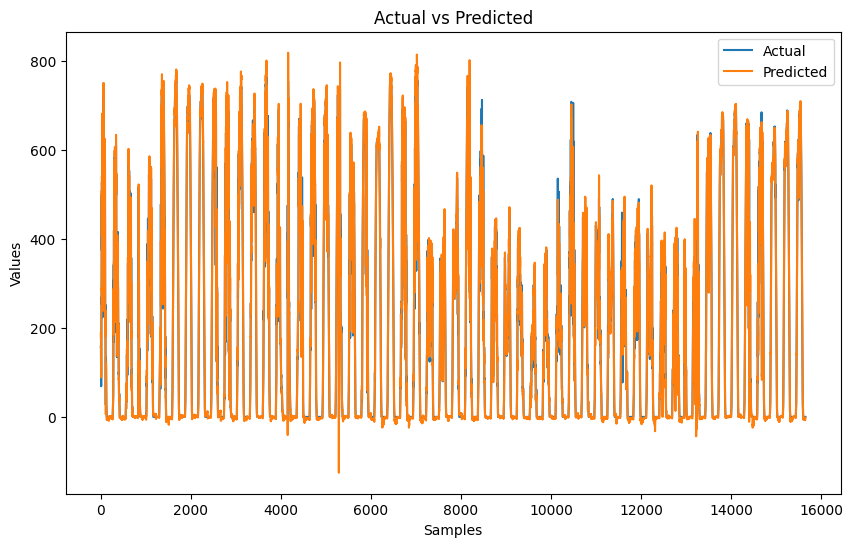

In [4]:
# 测试模型并反归一化
y_pred_lnn_scaled = model.predict(X_test_scaled)
y_pred_lnn = scaler_y.inverse_transform(y_pred_lnn_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

# 可视化预测结果与实际值对比
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_lnn, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

# 加载和使用保存的最佳超参数（如果需要）
# with open('best_hyperparameters.json', 'r') as f:
#     best_hps_dict = json.load(f)
# best_hps = tuner.oracle.hyperparameters.copy()
# for k, v in best_hps_dict.items():
#     best_hps[k] = v
# model = tuner.hypermodel.build(best_hps)